# Time-Series Models using Sktime and Statsmodels 

**Summary**
 NaiveForecaster, autoEST AutoARIMA EnsembleForecaster 
In this notebook we will forecast precipitation. Before we make any models we will check for any seaonsality in our data and determine if it's satationary or not. We decided that setting our time frame to 'months' will yeild the best results because our baseline model's MSE performed 0.02 better than the 'weekly' time frame. 

Baseline Model 
- We will use a NaiveForecaster as our baseline model. The mean of the last seasonal window is a brute-force method to establish a baseline.
  
Holt-Winters Model
- Using autoEST

SARIMA Model
- Using autoARIMA

Ensemble Forecaster Model
- Using SARIMA and Holt-Winters models 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series
import pmdarima as pmd
from sktime.forecasting.compose import EnsembleForecaster

In [2]:
df = pd.read_csv('../data/fresno_eda.csv', index_col='datetime', parse_dates=True)
df = pd.DataFrame(df['precip'])

In [3]:
df.shape

(10959, 1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10959 entries, 1992-01-01 to 2022-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   precip  10959 non-null  float64
dtypes: float64(1)
memory usage: 171.2 KB


In [58]:
df_month = df.resample('M').mean()

In [7]:
df_month.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 361 entries, 1992-01-31 to 2022-01-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   precip  361 non-null    float64
dtypes: float64(1)
memory usage: 5.6 KB


In [59]:
df_month.isnull().sum()

precip    0
dtype: int64

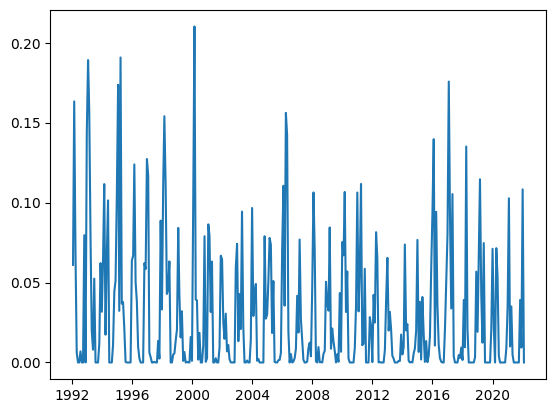

In [60]:
plt.plot(df_month)

In [10]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
    return dfoutput

In [12]:
interpret_dftest(adfuller(df_month))

Test Statistic    -3.848855
p-value            0.002445
Lag Used          12.000000
dtype: float64

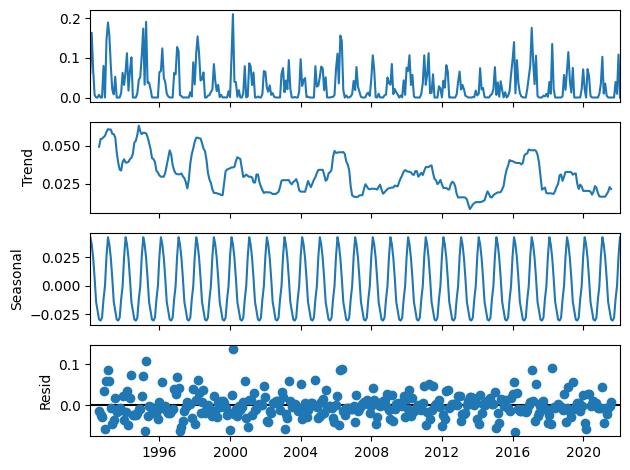

In [13]:

# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(df_month)

# Plot the decomposed time series.
decomp.plot();

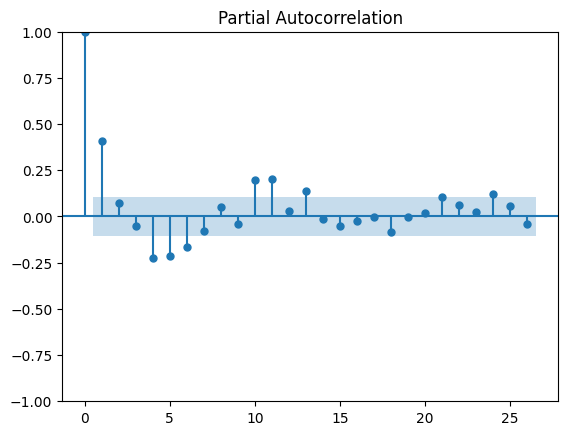

In [15]:
plot_pacf(df_month);

In [16]:
# No trends because a majority of our lags are close to or under 0. 

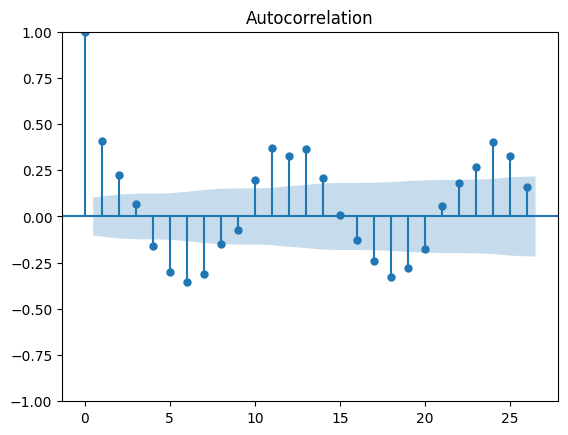

In [17]:
plot_acf(df_month);

In [48]:
train = df_month.loc['2005-09-01':'2021-09-01']

In [49]:
test = df_month.loc['2021-09-02':]

In [50]:
train.shape, test.shape

((192, 1), (5, 1))

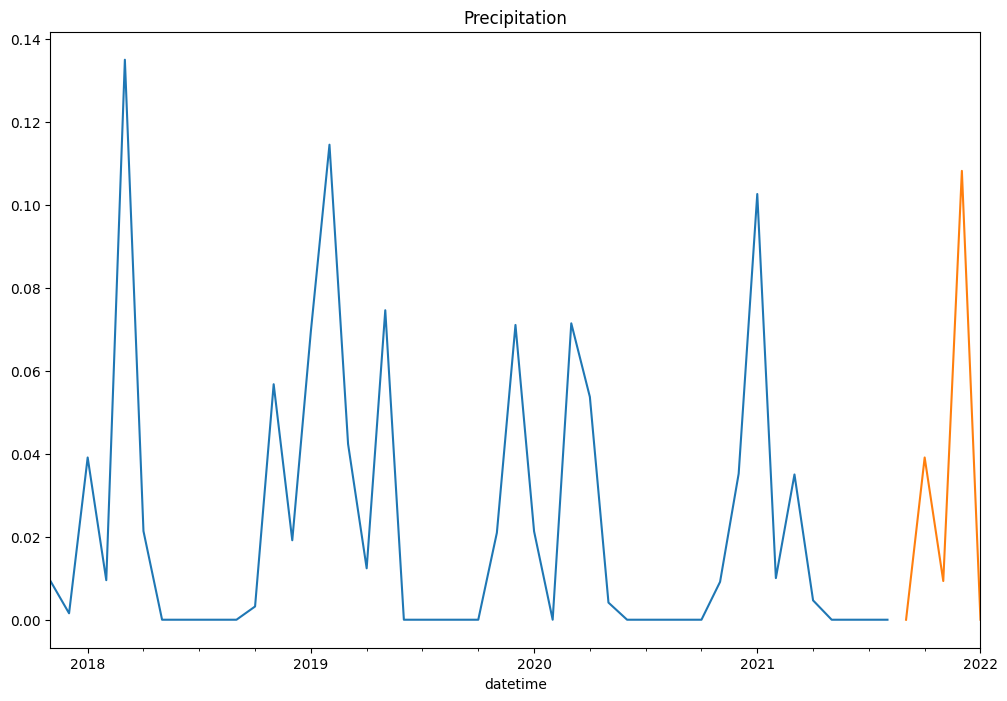

In [51]:
train['precip'].loc['2017-11-01':].plot()
test['precip'].plot(figsize = (12, 8), title = 'Precipitation');

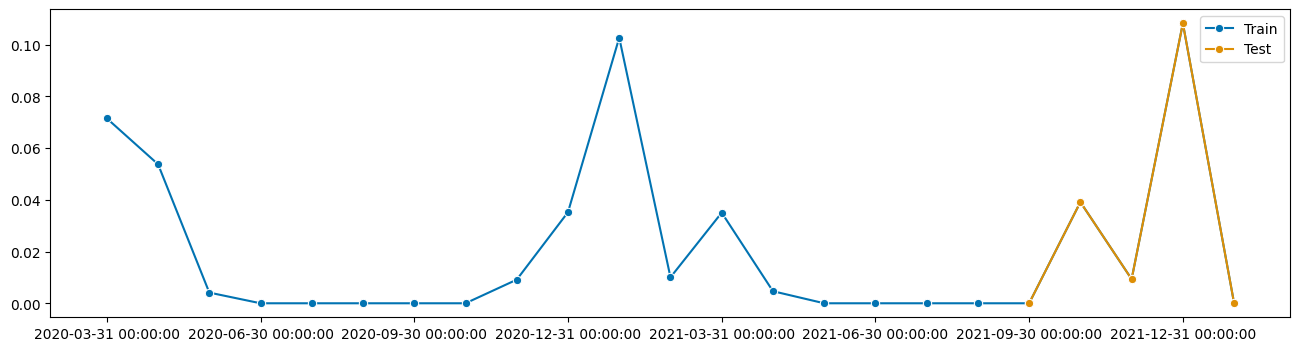

In [52]:
plot_series(df_month.loc['2020-03-02':], test, labels = ['Train', 'Test']);

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

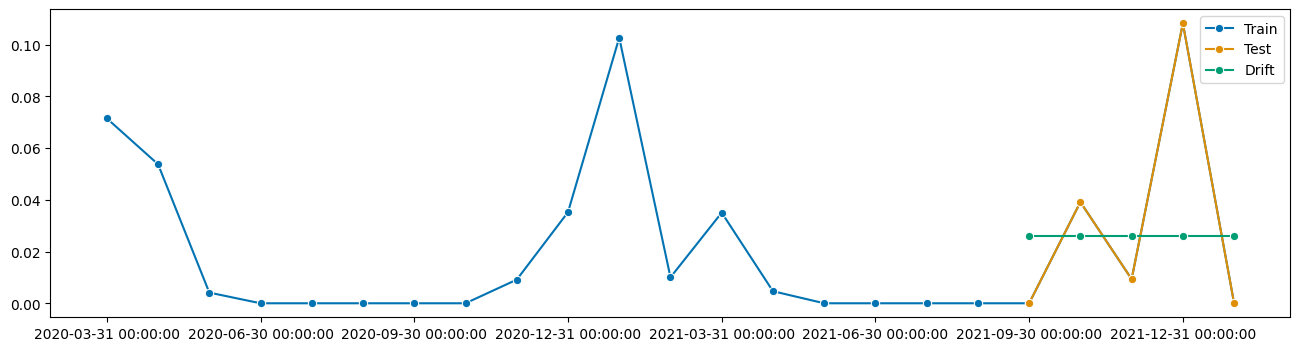

In [56]:

baseline_drift = NaiveForecaster(strategy = 'mean')

baseline_drift.fit(train)

baseline_drift_preds = baseline_drift.predict(test.index)

plot_series(df_month.loc['2020-03-02':], test, baseline_drift_preds, labels = ['Train', 'Test', 'Drift'])

In [57]:
mean_squared_error(test, baseline_drift_preds, squared=False)

0.04137363747374292

In [25]:
hw_model = AutoETS(sp = 12, seasonal='add', random_state=42)

hw_model.fit(train)

AutoETS(random_state=42, seasonal='add', sp=12)

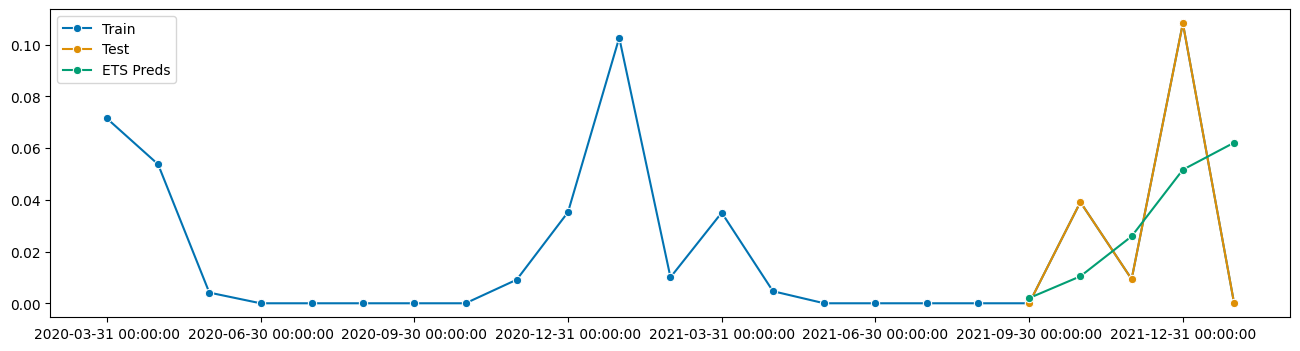

In [37]:

hw_preds = hw_model.predict(test.index)

plot_series(df_month.loc['2020-03-02':], test, hw_preds, labels = ['Train', 'Test', 'ETS Preds']);

In [27]:
mean_squared_error(test, hw_preds, squared=False)

0.04040582465609773

In [28]:
sarima_model = AutoARIMA(sp = 12, trace = True, suppress_warnings=True)

In [29]:
sarima_model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-773.789, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-724.159, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-753.232, Time=0.27 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-748.399, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-645.828, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-785.286, Time=0.43 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-786.709, Time=0.13 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-775.723, Time=0.36 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-749.574, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-748.899, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=-749.603, Time=0.11 sec
 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=-761.132, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-750.677, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[12] intercept   : AIC=-755.372, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0

AutoARIMA(sp=12, suppress_warnings=True, trace=True)

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

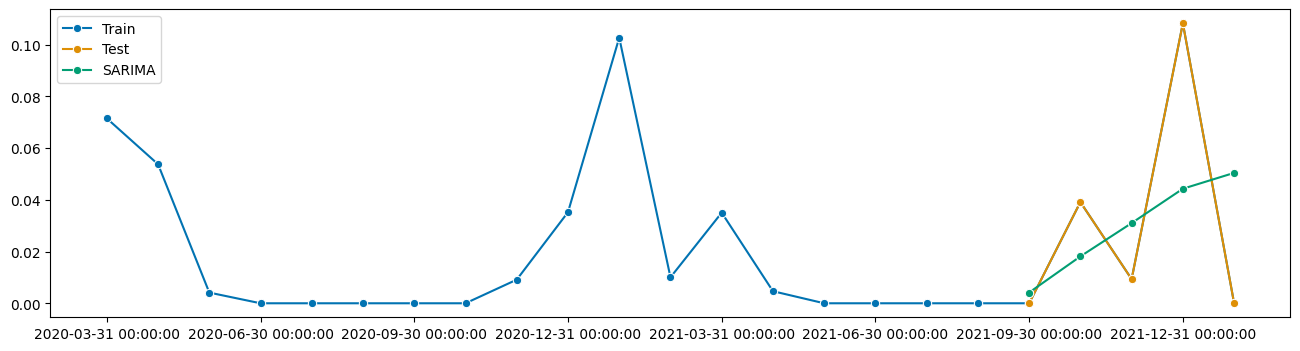

In [36]:

sarima_preds = sarima_model.predict(test.index)
plot_series(df_month.loc['2020-03-02':], test, sarima_preds,
           labels = ['Train', 'Test', 'SARIMA'])

In [31]:
mean_squared_error(test, sarima_preds, squared=False)

0.03888894984862489

In [32]:
forecaster = EnsembleForecaster([
    ('sarima', sarima_model),
    ('hw', hw_model)
], n_jobs = -1)

forecaster.fit(train)

ensemble_preds = forecaster.predict(test.index)

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

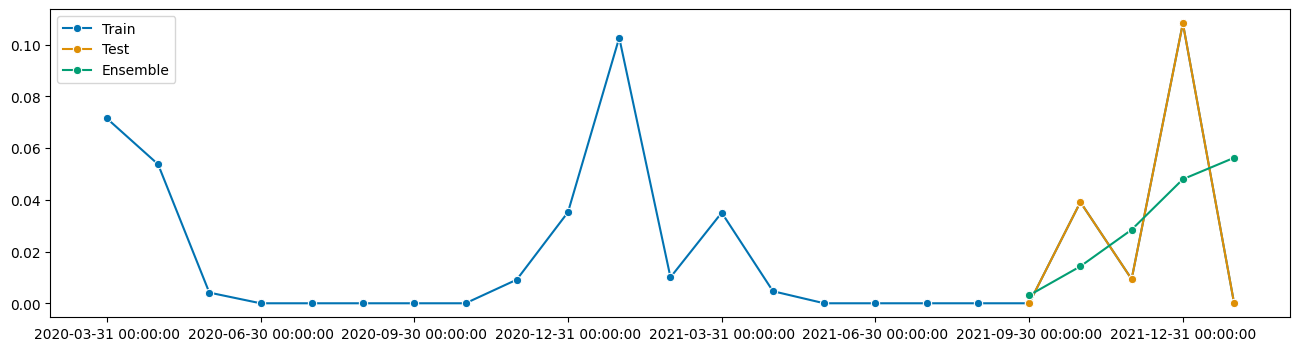

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-773.789, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-724.159, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-753.232, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-748.399, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-645.828, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-785.286, Time=0.24 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-786.709, Time=0.07 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-775.723, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-749.574, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-748.899, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=-749.603, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=-761.132, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-750.677, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[12] intercept   : AIC=-755.372, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0

In [40]:
plot_series(df_month.loc['2020-03-02':], test, ensemble_preds, labels = ['Train', 'Test', 'Ensemble'])

In [34]:
mean_squared_error(test, ensemble_preds,squared=False)

0.03947727232398758